# This is the pytorch implementation of the paper "Structural Similarity based Anatomical and Functional Brain Imaging Fusion"

In [1]:
import sys
sys.path.append("/home/h1/s8993054/.local/lib/python3.6/site-packages/") # go to parent dir

In [2]:
#Import packages
import time
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
import numpy as np
from torchvision import transforms
from torch.autograd import Variable
from PIL import Image
import torchvision.transforms.functional as TF
from torchvision.models.vgg import vgg19
import torch.nn as nn
import torch.nn.functional as F
import torch
from skimage import img_as_ubyte
import torch.nn as nn
import torch.utils.data as Data
import torchvision      # dataset
import matplotlib.pyplot as plt
import scipy
import numpy as np
import argparse
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import glob
import imageio
from skimage import color
import numpy
import natsort
import scipy
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
import pprint
from scipy.ndimage import correlate
from scipy.ndimage.filters import gaussian_gradient_magnitude
import torchvision.datasets as dset
import torch.utils.data as data
import os
import os.path
from tkinter import *
import tkinter as tk
import tkinter.font as tkFont
from PIL import ImageTk, Image
import pylab
import cv2
import h5py
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.font_manager import FontProperties

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.get_device_properties(0).total_memory)

33822867456


In [4]:
import multiprocessing

multiprocessing.cpu_count()

176

In [5]:
#define the hyperparameters
image_length = 256
image_width  = 256
mr_channels  = 1
gray_channels = 1
pet_channels = 4    
rgb_channels = 3     
batch_size   = 8
EPOCH = 200
learning_rate = 0.002

In [6]:
#load the train mri data
filenames = os.listdir('/home/h1/s8993054/Forschungprojekt/Training/MRI')
dataset = os.path.join(os.getcwd(), '/home/h1/s8993054/Forschungprojekt/Training/MRI')
data = glob.glob(os.path.join(dataset, "*.gif"))
data = natsort.natsorted(data,reverse=False)
train_mri = np.zeros((len(data), image_width,image_length))
for i in range(len(data)):
    train_mri[i,:,:] =(imageio.imread(data[i]))
    train_mri[i,:,:] =(train_mri[i,:,:] - np.min(train_mri[i,:,:])) / (np.max(train_mri[i,:,:]) - np.min(train_mri[i,:,:]))
    train_mri[i,:,:] = np.float32(train_mri[i,:,:])

In [7]:
#expand dimension to add the channel
train_mri = np.expand_dims(train_mri,axis=1)

In [8]:
#verify the shape matches the pytorch standard
train_mri.shape

(272, 1, 256, 256)

In [9]:
#convert the MRI training data to pytorch tensor
train_mri_tensor = torch.from_numpy(train_mri).float()
train_mri_tensor.shape

torch.Size([272, 1, 256, 256])

In [10]:
#load the train pet data
filenames = os.listdir('/home/h1/s8993054/Forschungprojekt/Training/PET')
dataset = os.path.join(os.getcwd(), '/home/h1/s8993054/Forschungprojekt/Training/PET')
data = glob.glob(os.path.join(dataset, "*.gif"))
data = natsort.natsorted(data,reverse=False)
train_other = np.zeros((len(data),image_width,image_length,pet_channels),dtype=float)
train_pet = np.zeros((len(data),image_width,image_length),dtype=float)
for i in range(len(data)):
    train_other[i,:,:,:] =(imageio.imread(data[i]))
    train_pet[i,:,:] = 0.2989 * train_other[i,:,:,0] + 0.5870 *  train_other[i,:,:,1]  + 0.1140 * train_other[i,:,:,2]
    train_pet[i,:,:] =(train_pet[i,:,:] - np.min(train_pet[i,:,:])) / (np.max(train_pet[i,:,:]) - np.min(train_pet[i,:,:]))

In [11]:
#expand the dimension to add the channel
train_pet = np.expand_dims(train_pet,axis=1)

In [12]:
#verify the shape matches the pytorch standard
train_pet.shape

(272, 1, 256, 256)

In [13]:
#convert the PET training data to pytorch tensor
train_pet_tensor = torch.from_numpy(train_pet).float()
train_pet_tensor.shape

torch.Size([272, 1, 256, 256])

In [14]:
#define the fusion network
class DeepPedestrian(nn.Module):
    def  __init__(self):
        super(DeepPedestrian, self).__init__()
        #####layer 1#####
        self.conv1 = nn.Sequential(                             #input shape  (,2,256,256)
                         nn.Conv2d(in_channels=2, out_channels=48, kernel_size=3, stride=1, padding=1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1)
                         )                                     #output shape (,48,256,256)   
        #####layer 2#####
        self.conv2 = nn.Sequential(                            #input shape  (,48,256,256)
                         nn.ReLU(),
                         nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1)
                         )                                     #output shape (,48,256,256)   
        #####layer 3#####
        self.conv3 = nn.Sequential(                            #input shape  (,48,256,256)
                         nn.ReLU(), 
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size=3, stride=1, padding=1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1)
                         )                                     #output shape (,48,256,256)     
        #####layer 4#####
        self.conv4 = nn.Sequential(                            #input shape  (,48,256,256)
                         nn.ReLU(), 
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size=3, stride=1, padding=1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1)
                         )                                      #output shape (,48,256,256)  
        #####layer 5#####
        self.conv5 = nn.Sequential(                             #input shape (, 48, 256, 256)
                          nn.ReLU(),
                          nn.Conv2d(in_channels  = 48,  out_channels = 1, kernel_size  = 3, stride = 1, padding = 1)) 
                                                                #output shape (,1, 256, 256)
        
    def forward(self, x, y):
        #layer 1
        x1 = self.conv1(torch.cat((x,y),dim=1))
        #layer 2
        x2 = self.conv2(x1)
        #residual layer
        x3 = x1+x2
        #layer 3
        x4 = self.conv3(x3)
        #layer 4
        x5 = self.conv4(x4)
        #residual layer
        x6 = x4 + x5
        #layer 5
        fused = self.conv5(x6)
        return fused
        #execute the network

cnn = DeepPedestrian().float()
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    cnn = nn.DataParallel(cnn)

cnn.to(device)

Let's use 6 GPUs!


DataParallel(
  (module): DeepPedestrian(
    (conv1): Sequential(
      (0): Conv2d(2, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (conv2): Sequential(
      (0): ReLU()
      (1): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU()
      (3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU()
      (7): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (conv3): Sequential(
      (0): ReLU()
      (1): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU()
      (3): Conv2d

In [15]:
#define the optimizers and loss functions 
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)   # optimize all cnn parameters
scheduler = StepLR(optimizer, step_size=25, gamma=0.1)
l2_loss   = nn.MSELoss() #MSEloss

In [16]:
# perform the training
counter = 0
start_time = time.time()
lamda = 0.99
gamma_ssim = 0.52
gamma_l2 = 0.5
ep_ssim_mri_loss = []
ep_ssim_pet_loss = []
ep_l2_mri_loss = []
ep_l2_pet_loss = []
for epoch in range(EPOCH):
    ssim_mri_Loss = []
    ssim_pet_Loss = []
    l2_mri_Loss = []
    l2_pet_Loss = []
    #run batch images
    batch_idxs = 272 // batch_size
    for idx in range(0, batch_idxs):
        b_x = train_mri_tensor[idx*batch_size : (idx+1)*batch_size,:,:,:].to(device)
        b_y = train_pet_tensor[idx*batch_size : (idx+1)*batch_size,:,:,:].to(device)
        counter += 1
        output = cnn(b_x,b_y)               # cnn output
        ssim_loss_mri = 1 - ssim(output, b_x,data_range=1)
        ssim_loss_pet = 1 - ssim(output, b_y,data_range=1)
        l2_loss_mri   = l2_loss(output,b_x)
        l2_loss_pet   = l2_loss(output,b_y)
        ssim_total = gamma_ssim*ssim_loss_mri + (1-gamma_ssim)*ssim_loss_pet
        l2_total = gamma_l2*l2_loss_mri + (1-gamma_l2)*l2_loss_pet
        loss_total = lamda*ssim_total + (1-lamda)*l2_total 
        optimizer.zero_grad()           # clear gradients for this training step
        loss_total.backward()           # backpropagation, compute gradients
        optimizer.step()                # apply gradients
    
        #store all the loss values at each epoch
        ssim_mri_Loss.append(ssim_loss_mri.item())
        ssim_pet_Loss.append(ssim_loss_pet.item())
        l2_mri_Loss.append(l2_loss_mri.item())
        l2_pet_Loss.append(l2_loss_pet.item())

        if counter % 100 == 0:
            print("Epoch: [%2d],step: [%2d], mri_ssim_loss: [%.8f], pet_ssim_loss: [%.8f],  total_ssim_loss: [%.8f], total_l2_loss: [%.8f], total_loss: [%.8f]" 
            %(epoch, counter, ssim_loss_mri, ssim_loss_pet, ssim_total, l2_total, loss_total))
            
    #learning schedule
    #scheduler.step()

    av_ssim_mri_loss = np.average(ssim_mri_Loss)
    ep_ssim_mri_loss.append(av_ssim_mri_loss)
    
    av_ssim_pet_loss = np.average(ssim_pet_Loss)
    ep_ssim_pet_loss.append(av_ssim_pet_loss)
    
    av_l2_mri_loss = np.average(l2_mri_Loss)
    ep_l2_mri_loss.append(av_l2_mri_loss)
    
    av_l2_pet_loss = np.average(l2_pet_Loss)
    ep_l2_pet_loss.append(av_l2_pet_loss)
    

    if(epoch == EPOCH -1):
      #Save a checkpoint
      torch.save(cnn, '/home/h1/s8993054/Forschungprojekt/DeepPedestrian/Checkpoint/checkpoint_lambda_0.99_gamma_ssim_0.52_gamma_l2_0.5.pth') 

Epoch: [ 2],step: [100], mri_ssim_loss: [0.25847572], pet_ssim_loss: [0.18528712],  total_ssim_loss: [0.22334519], total_l2_loss: [0.01468381], total_loss: [0.22125858]
Epoch: [ 5],step: [200], mri_ssim_loss: [0.32625175], pet_ssim_loss: [0.22081196],  total_ssim_loss: [0.27564064], total_l2_loss: [0.01192656], total_loss: [0.27300349]
Epoch: [ 8],step: [300], mri_ssim_loss: [0.58175731], pet_ssim_loss: [0.22356462],  total_ssim_loss: [0.40982479], total_l2_loss: [0.00957805], total_loss: [0.40582234]
Epoch: [11],step: [400], mri_ssim_loss: [0.29703748], pet_ssim_loss: [0.21513915],  total_ssim_loss: [0.25772628], total_l2_loss: [0.01367010], total_loss: [0.25528571]
Epoch: [14],step: [500], mri_ssim_loss: [0.26795030], pet_ssim_loss: [0.16893899],  total_ssim_loss: [0.22042486], total_l2_loss: [0.00963004], total_loss: [0.21831693]
Epoch: [17],step: [600], mri_ssim_loss: [0.20392525], pet_ssim_loss: [0.18475509],  total_ssim_loss: [0.19472358], total_l2_loss: [0.01338044], total_loss:

/software/ml/JupyterHub/conda-env-20191018-0822/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DeepPedestrian. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [49]:
l1 = np.asarray(ep_ssim_mri_loss)
l2 = np.asarray(ep_ssim_pet_loss)
l3 = np.asarray(ep_l2_mri_loss)
l4 = np.asarray(ep_l2_pet_loss)

In [59]:
h5f = h5py.File('/home/h1/s8993054/Forschungprojekt/DeepPedestrian/Loss curves/H5 Files/lamda_0.99/gamma_0.52_0.5_ssim_mri.h5', 'w')
h5f.create_dataset('data', data=l1)
h5f.close()

h5f = h5py.File('/home/h1/s8993054/Forschungprojekt/DeepPedestrian/Loss curves/H5 Files/lamda_0.99/gamma_0.52_0.5_ssim_pet.h5', 'w')
h5f.create_dataset('data', data=l2)
h5f.close()

h5f = h5py.File('/home/h1/s8993054/Forschungprojekt/DeepPedestrian/Loss curves/H5 Files/lamda_0.99/gamma_0.52_0.5_l2_mri.h5', 'w')
h5f.create_dataset('data', data=l3)
h5f.close()

h5f = h5py.File('/home/h1/s8993054/Forschungprojekt/DeepPedestrian/Loss curves/H5 Files/lamda_0.99/gamma_0.52_0.5_l2_pet.h5', 'w')
h5f.create_dataset('data', data=l4)
h5f.close()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


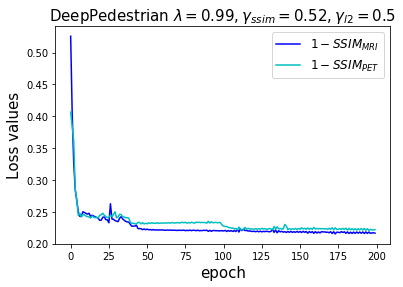

In [60]:
#FunFuseAn SSIM gamma_ssim = 0.1 gamma_l2 = 0.1
fontP = FontProperties()
fontP.set_size('large')
plt.plot(l1,'b',label='$1-SSIM_{MRI}$')
plt.plot(l2,'c',label='$1-SSIM_{PET}$')
plt.xlabel('epoch',fontsize= 15)
plt.ylabel('Loss values',fontsize= 15)
plt.legend(loc=1, prop=fontP)
plt.title('DeepPedestrian $\lambda = 0.99, \gamma_{ssim} = 0.52, \gamma_{l2} = 0.5$',fontsize='15')
plt.savefig('/home/h1/s8993054/Forschungprojekt/DeepPedestrian/Loss curves/Images/lamda_0.99/gamma_0.52_0.5_ssim.eps', format='eps', dpi=100)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


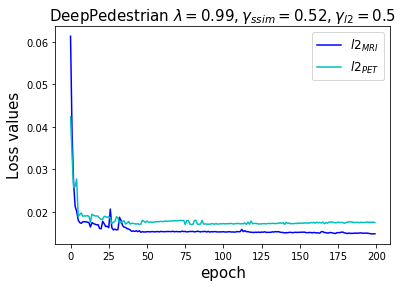

In [61]:
#FunFuseAn L2 gamma_ssim = 0.1 gamma_l2 = 0.1
fontP = FontProperties()
fontP.set_size('large')
plt.plot(l3,'b',label='$l2_{MRI}$')
plt.plot(l4,'c',label='$l2_{PET}$')
plt.xlabel('epoch',fontsize= 15)
plt.ylabel('Loss values',fontsize= 15)
plt.legend(loc=1, prop=fontP)
plt.title('DeepPedestrian $\lambda = 0.99, \gamma_{ssim} = 0.52, \gamma_{l2} = 0.5$',fontsize='15')
plt.savefig('/home/h1/s8993054/Forschungprojekt/DeepPedestrian/Loss curves/Images/lamda_0.99/gamma_0.52_0.5_l2.eps', format='eps', dpi=100)